In [22]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [23]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('vcb.csv')

In [24]:
# Xử lý dữ liệu
prices = data['Price']

In [25]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [26]:
scaled_prices

array([[0.08754242],
       [0.08647225],
       [0.091809  ],
       ...,
       [0.67895011],
       [0.68880691],
       [0.65782841]])

In [27]:
#RATIO 73

In [28]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [29]:
test_data

array([[0.66909332],
       [0.67613388],
       [0.68035822],
       [0.68599068],
       [0.64233916],
       [0.66205275],
       [0.66909332],
       [0.68599068],
       [0.69584747],
       [0.69584747],
       [0.69584747],
       [0.67613388],
       [0.66205275],
       [0.66064463],
       [0.65360407],
       [0.65501218],
       [0.65642029],
       [0.66627709],
       [0.66346086],
       [0.66909332],
       [0.69162313],
       [0.66909332],
       [0.66909332],
       [0.66064463],
       [0.66064463],
       [0.64093104],
       [0.62966614],
       [0.5944633 ],
       [0.5944633 ],
       [0.60432009],
       [0.60432009],
       [0.65782841],
       [0.65219595],
       [0.63389048],
       [0.64797161],
       [0.64797161],
       [0.63952293],
       [0.6254418 ],
       [0.64093104],
       [0.61840123],
       [0.59727952],
       [0.62684991],
       [0.62684991],
       [0.5846065 ],
       [0.52828196],
       [0.54517932],
       [0.57052537],
       [0.562

In [30]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [31]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [32]:
X_train.shape

(1011, 30, 1)

In [33]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [34]:
# 8. Define CNN-GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
16/16 [==============================] - 2s 6ms/step - loss: 0.0429
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 7.1373e-04
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 6.2043e-04
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 5.9711e-04
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 5.7899e-04
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 5.6382e-04
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 5.4652e-04
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 5.4986e-04
Epoch 11/100
16/16 [==============================] - 0s 6ms/step - loss: 5.1945e-04
Epoch 12/100
16/16 [==============================] - 0s 6ms/step - loss: 5.0761e-04
E

In [36]:
data.index


RangeIndex(start=0, stop=1488, step=1)

In [37]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

13/13 [==============================] - 0s 2ms/step
[[1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]
 [1516]
 [1517]
 [1518]]
1/1 [==============================] - 0s 261ms/step
[88374.11  88195.875 88766.266 87638.12  88843.25  87354.    85586.46
 85173.195 85679.9   87277.8   87402.86  84956.586 85441.125 86309.83
 86132.66  84867.88  85447.47  85387.34  85233.58  84578.016 84155.68
 84583.01  85580.01  84863.375 85293.13  84726.22  84431.65  83741.25
 83716.67  83294.71 ]


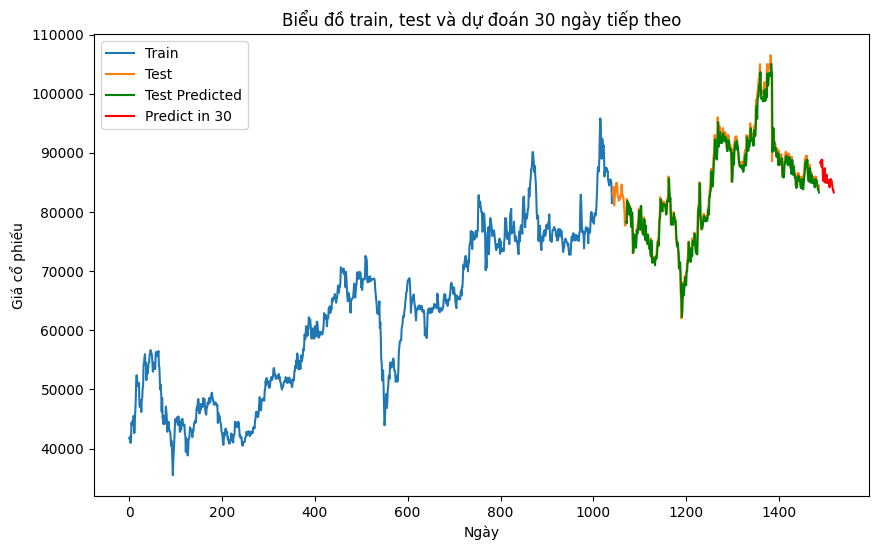

In [38]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [39]:
y_test_pred

array([[ 78294.375],
       [ 78080.26 ],
       [ 81890.94 ],
       [ 81534.4  ],
       [ 79647.45 ],
       [ 81082.03 ],
       [ 81301.36 ],
       [ 80412.49 ],
       [ 79438.68 ],
       [ 80675.51 ],
       [ 79120.4  ],
       [ 77427.48 ],
       [ 79776.71 ],
       [ 79905.92 ],
       [ 76528.28 ],
       [ 73097.36 ],
       [ 73950.42 ],
       [ 76199.945],
       [ 75078.484],
       [ 75453.336],
       [ 74997.945],
       [ 73945.34 ],
       [ 75322.42 ],
       [ 76884.02 ],
       [ 76344.9  ],
       [ 76936.586],
       [ 77749.18 ],
       [ 78578.83 ],
       [ 80221.46 ],
       [ 78604.664],
       [ 76962.58 ],
       [ 79505.96 ],
       [ 81007.016],
       [ 78660.55 ],
       [ 77272.77 ],
       [ 77436.18 ],
       [ 76166.7  ],
       [ 76644.93 ],
       [ 76308.25 ],
       [ 78775.67 ],
       [ 75834.45 ],
       [ 75239.83 ],
       [ 77675.89 ],
       [ 75745.79 ],
       [ 75315.125],
       [ 74782.98 ],
       [ 74552.13 ],
       [ 7610

In [40]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




13/13 [==============================] - 0s 2ms/step


In [41]:
y_test1

array([[ 78400.],
       [ 82200.],
       [ 81800.],
       [ 80500.],
       [ 81500.],
       [ 81500.],
       [ 80900.],
       [ 79900.],
       [ 81000.],
       [ 79400.],
       [ 77900.],
       [ 80000.],
       [ 80000.],
       [ 77000.],
       [ 73000.],
       [ 74200.],
       [ 76000.],
       [ 75400.],
       [ 76000.],
       [ 75300.],
       [ 74400.],
       [ 75600.],
       [ 77000.],
       [ 76700.],
       [ 77400.],
       [ 78000.],
       [ 78900.],
       [ 80500.],
       [ 79000.],
       [ 77500.],
       [ 79700.],
       [ 81000.],
       [ 79200.],
       [ 77800.],
       [ 77700.],
       [ 76400.],
       [ 77000.],
       [ 76500.],
       [ 79100.],
       [ 76100.],
       [ 76000.],
       [ 77700.],
       [ 76000.],
       [ 75900.],
       [ 75000.],
       [ 74900.],
       [ 76300.],
       [ 75500.],
       [ 74800.],
       [ 74000.],
       [ 74100.],
       [ 74000.],
       [ 72800.],
       [ 75500.],
       [ 74000.],
       [ 7

In [42]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 1.397
MAE: 1186.173
RMSE: 1671.542
MSLE: 0.019
-------------------
